Оригинал https://habr.com/ru/company/ods/blog/328372/

В задачах машинного обучения для оценки качества моделей и сравнения различных алгоритмов используются метрики, а их выбор и анализ — непременная часть работы датасатаниста.


В этой статье мы рассмотрим некоторые критерии качества в задачах классификации, обсудим, что является важным при выборе метрики и что может пойти не так.
<img src="../images/b33683d495964ebb9ca8d413e60c4085.jpg">

# Метрики в задачах классификации

Для демонстрации полезных функций sklearn и наглядного представления метрик мы будем использовать датасет по оттоку клиентов телеком-оператора.


In [17]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/telecom_churn.csv')
df.drop('Phone number', axis=1, inplace=True)

In [13]:
# Сделаем маппинг бинарных колонок 
# и закодируем dummy-кодированием штат (для простоты, лучше не делать так для деревянных моделей)

d = {'yes' : 1, 'no' : 0}

df['International plan'] = df['International plan'].map(d)
df['Voice mail plan'] = df['Voice mail plan'].map(d)
df['Churn'] = df['Churn'].astype('int64')

le = LabelEncoder()
df['State'] = le.fit_transform(df['State'])

ohe = OneHotEncoder(sparse=False)

encoded_state = ohe.fit_transform(df['State'].values.reshape(-1, 1))
tmp = pd.DataFrame(encoded_state,  
                   columns=['state ' + str(i) for i in range(encoded_state.shape[1])])
df = pd.concat([df, tmp], axis=1)

# Accuracy, precision и recall

Перед переходом к самим метрикам необходимо ввести важную концепцию для описания этих метрик в терминах ошибок классификации — confusion matrix (матрица ошибок).
Допустим, что у нас есть два класса и алгоритм, предсказывающий принадлежность каждого объекта одному из классов, тогда матрица ошибок классификации будет выглядеть следующим образом:

<img src="../images/Screenshot_from_2019-04-11_10-07-28.png">

Здесь  $\hat y$ — это ответ алгоритма на объекте, а  $y$ — истинная метка класса на этом объекте.
Таким образом, ошибки классификации бывают двух видов: False Negative (FN) и False Positive (FP).

Confusion matrix, without normalization
[[914  27]
 [118  41]]


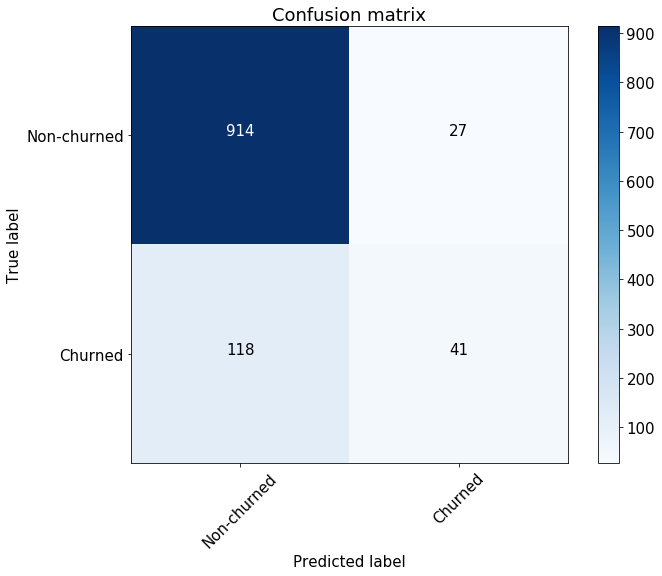

In [14]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# Делим выборку на train и test, все метрики будем оценивать на тестовом датасете

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.33, random_state=42)

# Обучаем ставшую родной логистическую регрессию

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

# Accuracy

Интуитивно понятной, очевидной и почти неиспользуемой метрикой является accuracy — доля правильных ответов алгоритма:

$$\large accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Эта метрика бесполезна в задачах с неравными классами, и это легко показать на примере.


Допустим, мы хотим оценить работу спам-фильтра почты. У нас есть 100 не-спам писем, 90 из которых наш классификатор определил верно (True Negative = 90, False Positive = 10), и 10 спам-писем, 5 из которых классификатор также определил верно (True Positive = 5, False Negative = 5).
Тогда accuracy:

$$\ accuracy = \frac{5 + 90}{5 + 90 + 10 + 5} = 86,4%$$

Однако если мы просто будем предсказывать все письма как не-спам, то получим более высокую accuracy:

$$\ accuracy = \frac{0 + 100}{0 + 100 + 0 + 10} = 90,9%$$

При этом, наша модель совершенно не обладает никакой предсказательной силой, так как изначально мы хотели определять письма со спамом. Преодолеть это нам поможет переход с общей для всех классов метрики к отдельным показателям качества классов.

# Precision, recall и F-мера

Для оценки качества работы алгоритма на каждом из классов по отдельности введем метрики precision (точность) и recall (полнота).

$$\large precision = \frac{TP}{TP + FP}$$

$$\large recall = \frac{TP}{TP + FN}$$

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

<img src="../images/38e9d4892d9241ea95e1f56e3ef9124c.png">

Именно введение precision не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня False Positive. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.


Как мы отмечали ранее, ошибки классификации бывают двух видов: False Positive и False Negative. В статистике первый вид ошибок называют ошибкой I-го рода, а второй — ошибкой II-го рода. В нашей задаче по определению оттока абонентов, ошибкой первого рода будет принятие лояльного абонента за уходящего, так как наша нулевая гипотеза состоит в том, что никто из абонентов не уходит, а мы эту гипотезу отвергаем. Соответственно, ошибкой второго рода будет являться "пропуск" уходящего абонента и ошибочное принятие нулевой гипотезы.


Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы в условиях несбалансированных выборок.
Часто в реальной практике стоит задача найти оптимальный (для заказчика) баланс между этими двумя метриками. Классическим примером является задача определения оттока клиентов.
Очевидно, что мы не можем находить всех уходящих в отток клиентов и только их. Но, определив стратегию и ресурс для удержания клиентов, мы можем подобрать нужные пороги по precision и recall. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдет с большей вероятностью, так как мы ограничены в ресурсах колл-центра.


Обычно при оптимизации гиперпараметров алгоритма (например, в случае перебора по сетке GridSearchCV ) используется одна метрика, улучшение которой мы и ожидаем увидеть на тестовой выборке.
Существует несколько различных способов объединить precision и recall в агрегированный критерий качества. F-мера (в общем случае ) — среднее гармоническое precision и recall :


$$\large \ F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$

$\beta$ в данном случае определяет вес точности в метрике, и при $\beta = 1$ это среднее гармоническое (с множителем 2, чтобы в случае precision = 1 и recall = 1 иметь $\ F_1 = 1$)
F-мера достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.
В sklearn есть удобная функция _metrics.classificationreport, возвращающая recall, precision и F-меру для каждого из классов, а также количество экземпляров каждого класса.








In [15]:
report = classification_report(y_test, lr.predict(X_test), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.89      0.97      0.93       941
    Churned       0.60      0.26      0.36       159

avg / total       0.84      0.87      0.84      1100



Здесь необходимо отметить, что в случае задач с несбалансированными классами, которые превалируют в реальной практике, часто приходится прибегать к техникам искусственной модификации датасета для выравнивания соотношения классов. Их существует много, и мы не будем их касаться, здесь можно посмотреть некоторые методы и выбрать подходящий для вашей задачи.

# AUC-ROC и AUC-PR

При конвертации вещественного ответа алгоритма (как правило, вероятности принадлежности к классу, отдельно см. SVM) в бинарную метку, мы должны выбрать какой-либо порог, при котором 0 становится 1. Естественным и близким кажется порог, равный 0.5, но он не всегда оказывается оптимальным, например, при вышеупомянутом отсутствии баланса классов.


Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является AUC-ROC (или ROC AUC) — площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve ). Данная кривая представляет из себя линию от (0,0) до (1,1) в координатах True Positive Rate (TPR) и False Positive Rate (FPR):


$$\large TPR = \frac{TP}{TP + FN}$$

$$\large FPR = \frac{FP}{FP + TN}$$

TPR нам уже известна, это полнота, а FPR показывает, какую долю из объектов negative класса алгоритм предсказал неверно. В идеальном случае, когда классификатор не делает ошибок (FPR = 0, TPR = 1) мы получим площадь под кривой, равную единице; в противном случае, когда классификатор случайно выдает вероятности классов, AUC-ROC будет стремиться к 0.5, так как классификатор будет выдавать одинаковое количество TP и FP.

Каждая точка на графике соответствует выбору некоторого порога. Площадь под кривой в данном случае показывает качество алгоритма (больше — лучше), кроме этого, важной является крутизна самой кривой — мы хотим максимизировать TPR, минимизируя FPR, а значит, наша кривая в идеале должна стремиться к точке (0,1).

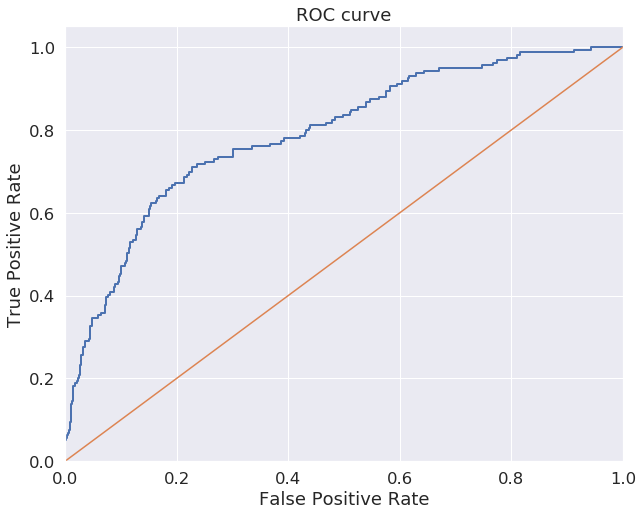

In [18]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# plt.savefig("ROC.png")
plt.show()

Критерий AUC-ROC устойчив к несбалансированным классам (спойлер: увы, не всё так однозначно) и может быть интерпретирован как вероятность того, что случайно выбранный positive объект будет проранжирован классификатором выше (будет иметь более высокую вероятность быть positive), чем случайно выбранный negative объект.


Рассмотрим следующую задачу: нам необходимо выбрать 100 релевантных документов из 1 миллиона документов. Мы намашинлернили два алгоритма:

* **Алгоритм 1** возвращает 100 документов, 90 из которых релевантны. Таким образом,

$$TPR = \frac{TP}{TP + FN} = \frac{90}{90 + 10} = 0.9$$

$$FPR = \frac{FP}{FP + TN} = \frac{10}{10 + 999890} = 0.00001$$

* **Алгоритм 2** возвращает 2000 документов, 90 из которых релевантны. Таким образом

$$TPR = \frac{TP}{TP + FN} = \frac{90}{90 + 10} = 0.9$$

$$FPR = \frac{FP}{FP + TN} = \frac{1910}{1910 + 997990} = 0.00191$$

Скорее всего, мы бы выбрали первый алгоритм, который выдает очень мало False Positive на фоне своего конкурента. Но разница в False Positive Rate между этими двумя алгоритмами крайне мала — всего 0.0019. Это является следствием того, что AUC-ROC измеряет долю False Positive относительно True Negative и в задачах, где нам не так важен второй (больший) класс, может давать не совсем адекватную картину при сравнении алгоритмов.


Для того чтобы поправить положение, вернемся к полноте и точности :

* **Алгоритм 1**

$$\ precision = \frac{TP}{TP + FP} = 90/(90 + 10) = 0.9$$

$$\ recall = \frac{TP}{TP + FN} = 90/(90 + 10) = 0.9$$

* **Алгоритм 2**

$$\ precision = \frac{TP}{TP + FP} = \frac{90}{90 + 1910} = 0.045$$

$$\ recall = \frac{TP}{TP + FN} = \frac{90}{90 + 10} = 0.9$$

Здесь уже заметна существенная разница между двумя алгоритмами — 0.855 в точности!


Precision и recall также используют для построения кривой и, аналогично AUC-ROC, находят площадь под ней.

<img src="../images/8873569147c24b49a2b7fa9ae883f20f.png">

Здесь можно отметить, что на маленьких датасетах площадь под PR-кривой может быть чересчур оптимистична, потому как вычисляется по методу трапеций, но обычно в таких задачах данных достаточно. За подробностями о взаимоотношениях AUC-ROC и AUC-PR можно обратиться __[сюда](http://http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)__.

# Logistic Loss

Особняком стоит логистическая функция потерь, определяемая как:

$$\large logloss = - \frac{1}{l} \cdot \sum_{i=1}^l (y_i \cdot log(\hat y_i) + (1 - y_i) \cdot log(1 - \hat y_i))$$

здесь $\hat y$ — это ответ алгоритма на $i$-ом объекте, $y$ — истинная метка класса на $i$-ом объекте, а $l$ размер выборки.

Подробно про математическую интерпретацию логистической функции потерь уже написано в рамках __[поста](https://habr.com/ru/company/ods/blog/323890/#princip-maksimalnogo-pravdopodobiya-i-logisticheskaya-regressiya)__ про линейные модели.
Данная метрика нечасто выступает в бизнес-требованиях, но часто — в задачах на kaggle.
Интуитивно можно представить минимизацию logloss как задачу максимизации accuracy путем штрафа за неверные предсказания. Однако необходимо отметить, что logloss крайне сильно штрафует за уверенность классификатора в неверном ответе.

Рассмотрим пример:

In [19]:
def logloss_crutch(y_true, y_pred, eps=1e-15):
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

print('Logloss при неуверенной классификации %f' % logloss_crutch(1, 0.5))
print('Logloss при уверенной классификации и верном ответе %f' % logloss_crutch(1, 0.9))
print('Logloss при уверенной классификации и НЕверном ответе %f' % logloss_crutch(1, 0.1))

Logloss при неуверенной классификации 0.693147
Logloss при уверенной классификации и верном ответе 0.105361
Logloss при уверенной классификации и НЕверном ответе 2.302585


Отметим, как *драматически* выросла logloss при неверном ответе и уверенной классификации!
Следовательно, ошибка на одном объекте может дать существенное ухудшение общей ошибки на выборке. Такие объекты часто бывают выбросами, которые нужно не забывать фильтровать или рассматривать отдельно.

Всё становится на свои места, если нарисовать график logloss:

<img src="../images/0fbe4eda3cb3469c8d02c837b53e564e.png">

Видно, что чем ближе к нулю ответ алгоритма при ground truth = 1, тем выше значение ошибки и круче растёт кривая.

# Подытожим:

* В случае многоклассовой классификации нужно внимательно следить за метриками каждого из классов и следовать логике решения задачи, а не оптимизации метрики
* В случае неравных классов нужно подбирать баланс классов для обучения и метрику, которая будет корректно отражать качество классификации
* Выбор метрики нужно делать с фокусом на предметную область, предварительно обрабатывая данные и, возможно, сегментируя (как в случае с делением на богатых и бедных клиентов)
